<a href="https://colab.research.google.com/github/bijanf/ESD_Workshop/blob/main/Downscaling_Workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A notebkook to demonstrate the statistical downscaling of CMIP6-like simulations

- Workshop 2023 October in tashkent
- We use the ISIMIP3a input data at 0.5 degree and downscale them using the CHELSA observation to 1 km
- We show the result for tas first and it could be extended to pr

In [ ]:
# import libraries:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")  # sklearn
import matplotlib.pyplot as plt
import seaborn as sns
#!./myenv/bin/pip xarray[complete]
import pandas as pd
import os
!pip install scikit-downscale
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation
import xarray as xr
from tqdm import tqdm
import numpy as np

!pip install cmocean
import cmocean
sns.set(style='darkgrid')
from skdownscale.pointwise_models import PointWiseDownscaler
!pip install --upgrade --no-cache-dir gdown
import gdown

In [ ]:
# Download the data to local area:

os.system("gdown --folder https://drive.google.com/drive/folders/1fT17hcbId14ibqxJqsscKSdHckRgInAt?usp=sharing")
#os.system("gdown --folder https://drive.google.com/drive/folders/1jIy4zlPMaN97k6wFLh6VSZJ5LnxKZXo8?usp=share_link")


0

In [ ]:
# parameters
train_slice = slice('1985', '2014')  # train time range
#holdout_slice = slice('2015', '2044')  # prediction time range
holdout_slice = slice('2070', '2099')  # prediction time range
# bounding box of downscaling region
# region:
city="tashkent"
lat0=41.25
lat1=41.75
lon0=68.75
lon1=69.25


ssp="ssp585"
var="tas"
lon_slice = slice(lon0, lon1) #90
lat_slice = slice(lat0, lat1) #60

In [ ]:
# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}


In [ ]:
# Read gridded Observation dataset:
fnames = [f'/content/Tashkent/chelsa_CA_{year}_tashkent.nc'
for year in range(int(train_slice.start), int(train_slice.stop) + 1)]
obs = xr.open_mfdataset(fnames, engine='h5netcdf', concat_dim='time',combine='nested')
# Select the latitude and longitude and make daily averages:
obs_subset = obs[var].sel(time=train_slice, lon=lon_slice, lat=lat_slice).resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

In [ ]:
# Read the future scenario file:
ssp = xr.open_dataset('/content/Tashkent/models/mpi-esm1-2-hr_r1i1p1f1_w5e5_tas_'+ssp'_tashkent.nc', engine='h5netcdf')
ds_model_ssp = ssp[var].squeeze(drop=True)
ds_model_ssp = ds_model_ssp.reindex(lat=ds_model_ssp.lat[::-1])
# read the historical simulation file:
hist = xr.open_dataset('/content/Tashkent/models/mpi-esm1-2-hr_r1i1p1f1_w5e5_historical_tas_tashkent.nc', engine='h5netcdf')
ds_model_hist = hist[var].squeeze(drop=True)
ds_model_hist = ds_model_hist.reindex(lat=ds_model_hist.lat[::-1])


In [ ]:
#interpolat the simulation to the observation grid:
train_subset = ds_model_hist.sel(time=train_slice).interp_like(obs_subset.isel(time=0,drop=True), method='linear')

In [ ]:
# select the same time axis
train_subset['time'] = pd.to_datetime(train_subset.indexes['time'])
train_subset = train_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)
# romove nan values if any:
train_subset = train_subset.dropna(dim="time", how="any")
obs_subset_new = obs_subset.sel(time=train_subset.time)

In [ ]:
# same preprocessing also for the future scenarios:
holdout_subset = ds_model_ssp.sel(time=holdout_slice).interp_like(obs_subset.isel(time=0,
                                                                                           drop=True), method='linear')
holdout_subset['time'] = pd.to_datetime(holdout_subset.indexes['time'])
holdout_subset = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

In [ ]:
##########################################################
#               Train the model
##########################################################
model = PointWiseDownscaler(BcsdTemperature(return_anoms=False))
   #    model
train_subset = train_subset.fillna(-300)
obs_subset = obs_subset.fillna(-300)
model.fit(train_subset, obs_subset_new)


##########################################################
#               peredict
##########################################################
holdout_subset = holdout_subset.dropna(dim="time", how="any")

print(holdout_subset.shape)
print('-------------------')
print()
print()
predicted = model.predict(holdout_subset).load()


##########################################################
#               Save the results
##########################################################
predicted.to_netcdf('predicted_'+str(int(holdout_slice.start))+'_'+str(int(holdout_slice.stop))+'_'+ssp+'.nc')

(10957, 60, 60)
-------------------




## Poltting the Results

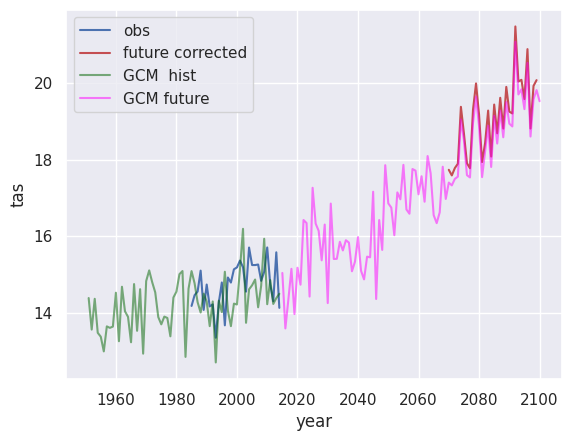

In [ ]:
def plot_yearly_mean(file, color, alpha, label):
  # Calculate the mean value over all lon and lat values
  mean_tas = file.mean(dim=['lon', 'lat'])
  # Group by year and take the mean
  yearly_mean = mean_tas.groupby('time.year').mean() -273.15
  # Plot the monthly mean as a line chart
  yearly_mean.plot(color=color, alpha=alpha, label = label)
  plt.legend()

plot_yearly_mean(obs_subset, "b",1,'obs')
plot_yearly_mean(predicted, "r",1,'future corrected')
plot_yearly_mean(ds_model_hist, "darkgreen",.5,"GCM  hist")
plot_yearly_mean(ds_model_ssp, "magenta", .5, "GCM future")


In [ ]:
obs_subset

<xarray.DataArray 'tas' (time: 10957, lat: 60, lon: 60)>
dask.array<where, shape=(10957, 60, 60), dtype=float32, chunksize=(10957, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 68.75 68.76 68.77 68.78 ... 69.22 69.23 69.24 69.25
  * lat      (lat) float64 41.25 41.26 41.27 41.28 ... 41.72 41.73 41.74 41.75
  * time     (time) datetime64[ns] 1985-01-01 1985-01-02 ... 2014-12-31
Attributes:
    standard_name:  air_temperature
    long_name:      Near-Surface Air Temperature
    units:          K

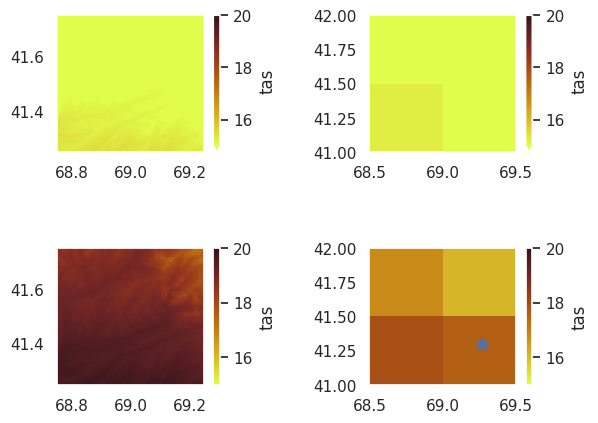

In [ ]:
# Calculate the time average for each data array
obs_subset_mean = obs_subset.mean(dim='time') -273.15
ds_model_hist_mean = ds_model_hist.sel(time=train_slice).mean(dim='time') -273.15
predicted_mean = predicted.mean(dim='time')-273.15
ds_model_ssp_mean = ds_model_ssp.mean(dim='time')-273.15

# Plot the time average as a pcolormesh for each data array
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(nrows=2, ncols=2)
obs_subset_mean.plot.pcolormesh(ax=ax1,x="lon", y="lat",cmap=cmocean.cm.solar_r, vmin=15, vmax=20)
ds_model_hist_mean.plot.pcolormesh(ax=ax2,x="lon", y="lat",cmap=cmocean.cm.solar_r, vmin=15, vmax=20)
predicted_mean.plot.pcolormesh(ax=ax3,x="lon", y="lat",cmap=cmocean.cm.solar_r, vmin=15, vmax=20)
ds_model_ssp_mean.plot.pcolormesh(ax=ax4,x="lon", y="lat",cmap=cmocean.cm.solar_r, vmin=15, vmax=20)

# Plot the coordinates of Tashkent with a star marker
ax4.scatter(69.2666656, 41.2999988 , marker="*", color="b", s=100)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.7, wspace=0.7)
ax1.set_xlabel('')
#ax1.set_title('Observation')

ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')

ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')

plt.show()


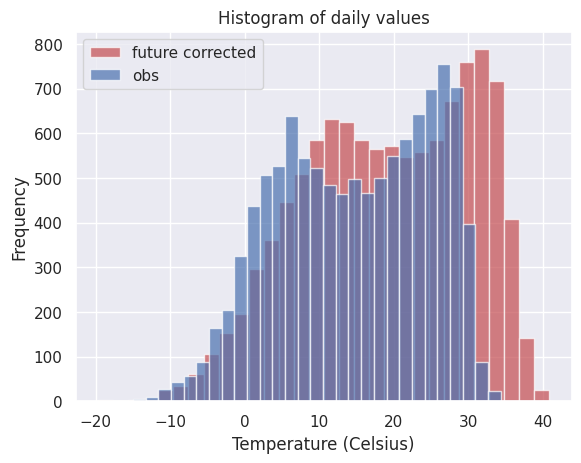

In [ ]:
import matplotlib.pyplot as plt

def plot_histogram(file, color, alpha, label):
  # Get the array of daily values
  daily_values = file.mean(dim=['lon', 'lat']).values - 273.15
  # Plot the histogram of daily values
  plt.hist(daily_values, bins=30, color=color, alpha=alpha, label=label)
  plt.legend()
plot_histogram(predicted, "r",.71,'future corrected')
plot_histogram(obs_subset, "b",.71,'obs')

#plot_histogram(ds_model_hist, "darkgreen",.5,"GCM  hist")
#plot_histogram(ds_model_ssp, "magenta", .5, "GCM future")

# Set the x-axis label
plt.xlabel('Temperature (Celsius)')

# Set the y-axis label
plt.ylabel('Frequency')

# Set the title
plt.title('Histogram of daily values')

plt.show()
